In [2]:
import tensorflow as tf
tf.config.experimental.set_visible_devices(devices=tf.config.experimental.list_physical_devices(device_type='GPU')[0], device_type='GPU')
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.__version__)
print(tf.config.list_physical_devices(), tf.test.is_gpu_available(),  tf.test.is_built_with_cuda())

2.4.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] True True


In [3]:
# DATA PREPARE

df = pd.read_csv("Oslo_weather_data-2010-2021.csv", sep=';') # Load csv

df[['Date','Hour']] = df.Tid.str.split(" ", expand=True) # Split to Date and Hour

df["Tid"] = pd.to_datetime(df.Tid, format='%d.%m.%Y %H:%M') # Set Tid to datetime pd object
df = df.sort_values(['Tid']) # sort by new Tid

df['Hour'] = df.Hour.str.split(":").str[0] # xx:yy -> xx
df[['Day','Month','Year']] = df.Date.str.split(".", expand=True)  # Date to day, month year col
del df["Date"] # Delete old Date col

df[df.columns[3:]] = df[df.columns[3:]].replace("-", 0) # 
print(df.tail())

                  Navn  Stasjon                 Tid Nedbør  Lufttemperatur  \
92806  Oslo - Blindern  SN18700 2021-02-26 18:00:00      0             8.5   
92807  Oslo - Blindern  SN18700 2021-02-26 19:00:00      0             7.3   
92808  Oslo - Blindern  SN18700 2021-02-26 20:00:00      0             4.4   
92809  Oslo - Blindern  SN18700 2021-02-26 21:00:00      0             2.6   
92810  Oslo - Blindern  SN18700 2021-02-26 22:00:00      0             2.1   

      Høyeste vindkast Middelvind Vindretning Hour Day Month  Year  
92806              5.2        2.9         335   18  26    02  2021  
92807              6.7        3.8         325   19  26    02  2021  
92808              5.1          2          32   20  26    02  2021  
92809              3.1        1.1         100   21  26    02  2021  
92810              3.1        1.6         349   22  26    02  2021  


In [7]:
# SCALING

scaler = MinMaxScaler(feature_range=(0, 1))

training_col = df.columns[3:9]
train = scaler.fit_transform(df[training_col])
FEATURES = df[training_col].columns
N_FEATURES = len(FEATURES)
print(FEATURES, N_FEATURES)
print(scaler.scale_)

Index(['Nedbør', 'Lufttemperatur', 'Høyeste vindkast', 'Middelvind',
       'Vindretning', 'Hour'],
      dtype='object') 6
[0.02242152 0.01828154 0.04310345 0.08       0.00277778 0.04347826]


In [185]:
# DATA PREP
PREV_HOURS = 48
NEXT_HOURS = 12

VALIDATION_SPLIT = 0.09 # a last year

trainX = []
trainY = []
for i in range(PREV_HOURS, len(train)-NEXT_HOURS):
    previous_days = []
    for j in range(PREV_HOURS):
        previous_days.append(train[i-j])

    next_days = []
    for j in range(1,NEXT_HOURS+1):
        next_days.append(train[i+j])

    trainX.append(previous_days)
    trainY.append(next_days)

trainX = np.array(trainX)
_trainY = np.array(trainY)
trainY = _trainY.reshape(_trainY.shape[0], N_FEATURES*NEXT_HOURS)

dataset_size = trainX.shape[0]
valid_size = int(dataset_size*VALIDATION_SPLIT)

validX = trainX[-valid_size:]
validY = trainY[-valid_size:]

trainX = trainX[:-valid_size]
trainY = trainY[:-valid_size]

print(trainX.shape, validX.shape)
print(trainY.shape, validY.shape)
#print(np.amax(trainX.reshape(-1,1)), np.amin(trainX.reshape(-1,1)))
assert (trainX.shape[0]+validX.shape[0]) == dataset_size

(88942, 48, 6) (8796, 48, 6)
(88942, 72) (8796, 72)


In [5]:
hour=214
feature=0
show_y = trainY[-720:].reshape(720, NEXT_HOURS, N_FEATURES)[:,0,0]
#print(show_y.shape)
#lt.plot(df["Lufttemperatur"][-720:],"b")
#plt.plot(show_y,"r")

In [187]:
# MODEL CREATION

n_timesteps = PREV_HOURS
n_features = trainX.shape[2]
n_futures = NEXT_HOURS
print(n_timesteps,n_features,n_timesteps*n_features)

TYPE_NAME = "2xCNN-B128-v2"
model = keras.Sequential()
'''
model.add(layers.Bidirectional(layers.LSTM(200, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
'''

model.add(layers.Conv1D(filters=512, kernel_size=2, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=128, kernel_size=2, input_shape=(n_timesteps, n_features)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())


#model.add(layers.GRU(128, input_shape=(n_timesteps, n_features), return_sequences=False))
#model.add(layers.BatchNormalization())
#model.add(layers.Flatten())

model.add(layers.Dense(N_FEATURES*n_futures, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(N_FEATURES*n_futures, activation='softmax'))
# Model End

opt = tf.keras.optimizers.Adam(lr=0.005, decay=1e-6)

NAME = f"{TYPE_NAME}-SEQ-{PREV_HOURS}-FUTR-{NEXT_HOURS}-{int(time.time())}"
filepath = NAME+"_model-{epoch:02d}-{val_accuracy:.3f}"

model.compile(optimizer=opt, loss="mse", metrics="accuracy") 
checkpoint = ModelCheckpoint(".\\models\\{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'), verbose=0, period=4) # saves only the best ones
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME), profile_batch=0)


# TRAINING
EPOCHS = 32
BATCH_SIZE = 2048
print("Training: "+NAME) 
history = model.fit(x=trainX, y=trainY, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(validX, validY), callbacks=[tensorboard, checkpoint]) # Train

model.save(f"./models/latest-{NAME}-e{EPOCHS}")

score = model.evaluate(validX, validY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


48 6 288
Training: 2xCNN-B128-v2-SEQ-48-FUTR-12-1614527689
Epoch 1/32
44/44 [==============================] - 9s 182ms/step - loss: 0.1459 - accuracy: 0.1959 - val_loss: 0.1546 - val_accuracy: 0.1863
Epoch 2/32
44/44 [==============================] - 7s 152ms/step - loss: 0.1422 - accuracy: 0.4516 - val_loss: 0.1542 - val_accuracy: 0.2132
Epoch 3/32
25/44 [================>.............] - ETA: 2s - loss: 0.1422 - accuracy: 0.5537

KeyboardInterrupt: 

In [18]:
model.save(f"./models/latest-{NAME}-e{EPOCHS}") # Save prev model

INFO:tensorflow:Assets written to: ./models/latest-2xCNN-SEQ-48-FUTR-12-1614453228-e96\assets
INFO:tensorflow:Assets written to: ./models/latest-2xCNN-SEQ-48-FUTR-12-1614453228-e96\assets


In [73]:
model = keras.models.load_model(f"./models/2xBiLSTM-B128_model-28-0.744.model") # Load a model

[0.01828154 0.04310345 0.08       0.00277778 0.04347826]


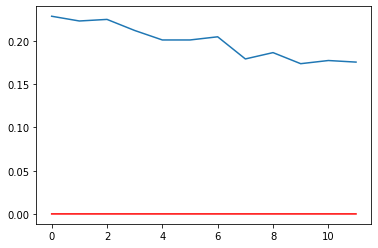

In [137]:
def inv(sc, s):
    x = s.reshape(n_futures,N_FEATURES)
    return sc.inverse_transform(x)

np.set_printoptions(suppress=True)

# PREDICTION CODE
i=231
p_input = trainX[i].reshape(1, trainX[i].shape[0], trainX[i].shape[1])
p_output = trainY[i]

pred = model.predict(p_input)
#print(pred.reshape(NEXT_HOURS,N_FEATURES)[:])

#print(pred.reshape(NEXT_HOURS,N_FEATURES)[:,0])
#r_pred = scaler.inverse_transform()
#r_real = inv(scaler, p_output)
#print(r_pred[0][0], r_real[0][0])

print(scaler.scale_)

#print(p_output.reshape(NEXT_HOURS,N_FEATURES)[:,0])
#print(pred.reshape(NEXT_HOURS,N_FEATURES)[:,0].shape)
#print("AAAA",pred.reshape(NEXT_HOURS,N_FEATURES)[:,0])
plt.plot(pred.reshape(NEXT_HOURS,N_FEATURES)[:,0]*54, "r")
#print(p_output.reshape(NEXT_HOURS,N_FEATURES)[:,0].shape)
plt.plot(p_output.reshape(NEXT_HOURS,N_FEATURES)[:,0])
#print(pred.reshape(NEXT_HOURS,N_FEATURES)[:,0])
#plt.plot(r_pred[:,0],'r')

In [138]:
pred_arr = model.predict(validX)

(8796, 12)
(8796,)


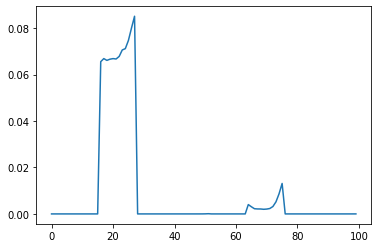

In [170]:
unpacked_arr = pred_arr.reshape(pred_arr.shape[0], NEXT_HOURS, N_FEATURES)
pred_future_temp = unpacked_arr[:,0]
r_pred_arr = scaler.inverse_transform(pred_future_temp)
print(unpacked_arr[:,:,0].shape)
allt = unpacked_arr[:,:,0]
n = []
for i in range(0,8796,12):
    n.extend(allt[i])
print(np.array(n).shape)
plt.plot(n[-100:])

(8796, 5)


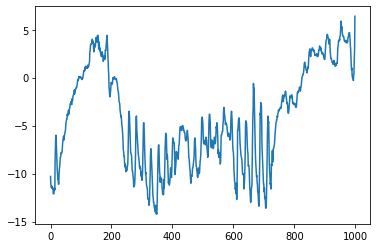

In [164]:
print(validY.reshape(validY.shape[0], NEXT_HOURS, N_FEATURES)[:,0].shape)
r_valid = scaler.inverse_transform(validY.reshape(validY.shape[0], NEXT_HOURS, N_FEATURES)[:,0])
plt.plot(r_valid[-1000:,0])